In [1]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from typing import List

In [2]:
apple_stock = pd.read_csv("data/aapl.us.txt", parse_dates=['Date'])

In [3]:
apple_stock.shape

(8364, 7)

In [4]:
apple_stock.head(10)

,Date,Open,High,Low,Close,Volume,OpenInt
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0
5,1984-09-14,0.44052,0.45589,0.44052,0.44566,68847968,0
6,1984-09-17,0.45718,0.46357,0.45718,0.45718,53755262,0
7,1984-09-18,0.45718,0.46103,0.44052,0.44052,27136886,0
8,1984-09-19,0.44052,0.44566,0.43157,0.43157,29641922,0
9,1984-09-20,0.43286,0.43668,0.43286,0.43286,18453585,0


In [5]:
apple_stock["Date"].min(), apple_stock["Date"].max()


(Timestamp('1984-09-07 00:00:00'), Timestamp('2017-11-10 00:00:00'))

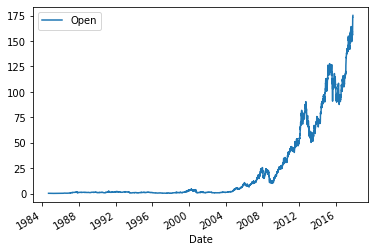

In [6]:
apple_stock.plot(x='Date', y="Open")


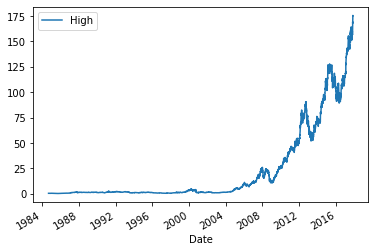

In [7]:
apple_stock.plot(x='Date', y="High")

In [8]:
apple_stock[["Open", "Close", "Low", "High"]].corr()

,Open,Close,Low,High
Open,1.000000,0.999902,0.999942,0.999956
Close,0.999902,1.000000,0.999955,0.999953
Low,0.999942,0.999955,1.000000,0.999928
High,0.999956,0.999953,0.999928,1.000000


In [9]:
apple_stock_6 = apple_stock[apple_stock["Date"] > apple_stock["Date"].max() - timedelta(days=365*6)]

In [10]:
apple_stock_6.shape

(1509, 7)

In [11]:
apple_stock_6["Date"].min(), apple_stock_6["Date"].max()

(Timestamp('2011-11-14 00:00:00'), Timestamp('2017-11-10 00:00:00'))

* train test split

In [12]:
train_size = int(apple_stock_6.shape[0] * 0.8)
train_df = apple_stock_6.iloc[:train_size]
val_df = apple_stock_6.iloc[train_size:]

In [13]:
train_df.shape, val_df.shape

((1207, 7), (302, 7))

In [14]:
train_df["Date"].min(), train_df["Date"].max(), val_df["Date"].min(), val_df["Date"].max()

(Timestamp('2011-11-14 00:00:00'),
 Timestamp('2016-08-31 00:00:00'),
 Timestamp('2016-09-01 00:00:00'),
 Timestamp('2017-11-10 00:00:00'))

In [15]:
scaler = StandardScaler()
scaler.fit(train_df[["Low"]])

def make_dataset(df, window_size, batch_size, use_scaler=True, shuffle=True):

  features = df[["Low"]].iloc[:-window_size]

  if use_scaler:
    features = scaler.transform(features)

  data = np.array(features, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data, targets=df["Low"].iloc[window_size:],
      sequence_length=window_size, sequence_stride=1,
      shuffle=shuffle, batch_size=batch_size)

  return ds

In [16]:
example_ds = make_dataset(df=train_df, window_size=3, batch_size=2, use_scaler=False, shuffle=False)


In [17]:
example_feature, example_label = next(example_ds.as_numpy_iterator())

In [18]:
example_feature.shape, example_label.shape

((2, 3, 1), (2,))

In [19]:
train_df["Low"].iloc[:6]

6855    48.432
6856    48.592
6857    49.217
6858    48.086
6859    48.009
6860    46.860
Name: Low, dtype: float64

In [20]:
print(example_feature[0])
print(example_label[0])

[[48.432]
 [48.592]
 [49.217]]
48.086000000000006


In [21]:
print(example_feature[1])
print(example_label[1])

[[48.592]
 [49.217]
 [48.086]]
48.00899999999999


In [22]:
window_size = 10
batch_size = 8
train_ds = make_dataset(df=train_df, window_size=window_size, batch_size=batch_size, use_scaler=True, shuffle=True)
val_ds = make_dataset(df=val_df, window_size=window_size, batch_size=batch_size, use_scaler=True, shuffle=True)

In [23]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(1)
])

In [24]:
def compile_and_fit(model, train_ds, val_ds, num_epochs: int = 20):
  model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(train_ds, epochs=num_epochs, validation_data=val_ds, verbose=0)
  return history

In [27]:
history = compile_and_fit(lstm_model, train_ds, val_ds, num_epochs=100)

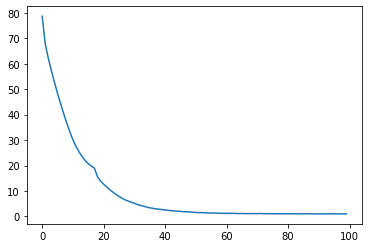

In [28]:
plt.plot(history.history["mean_absolute_error"])

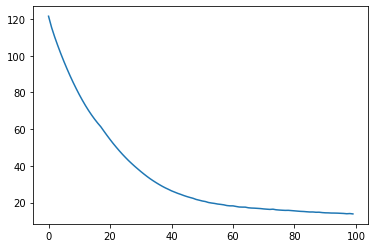

In [29]:
plt.plot(history.history["val_mean_absolute_error"])

* overfiting

In [30]:
lstm_model.evaluate(train_ds)

149/149 [==============================] - 0s 3ms/step - loss: 2.1312 - mean_absolute_error: 1.0143


[2.131227731704712, 1.014333963394165]

In [32]:
lstm_model.evaluate(val_ds)

36/36 [==============================] - 0s 2ms/step - loss: 325.2900 - mean_absolute_error: 13.8601


[325.2900390625, 13.860065460205078]

In [33]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

history = compile_and_fit(lstm_model, train_ds, val_ds, num_epochs=500)

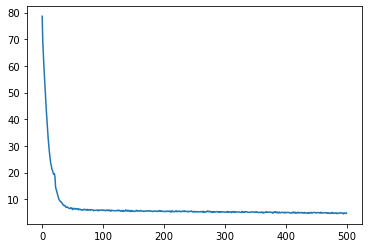

In [34]:
plt.plot(history.history["mean_absolute_error"])

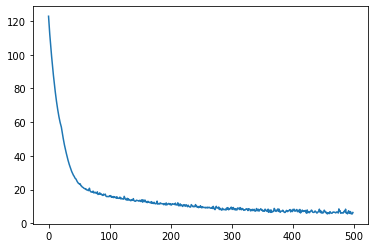

In [35]:
plt.plot(history.history["val_mean_absolute_error"])


In [36]:
lstm_model.evaluate(train_ds)

149/149 [==============================] - 0s 3ms/step - loss: 2.3014 - mean_absolute_error: 1.0626


[2.3014466762542725, 1.0625709295272827]

In [37]:
lstm_model.evaluate(val_ds)

36/36 [==============================] - 0s 2ms/step - loss: 67.0219 - mean_absolute_error: 6.4249


[67.02190399169922, 6.424896240234375]

In [38]:
history = compile_and_fit(lstm_model, train_ds, val_ds, num_epochs=900)

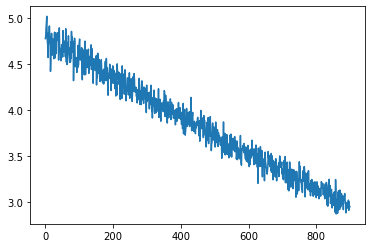

In [39]:
plt.plot(history.history["mean_absolute_error"])

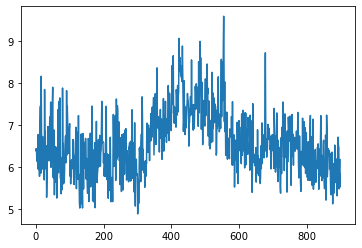

In [40]:
plt.plot(history.history["val_mean_absolute_error"])

In [41]:
lstm_model.evaluate(train_ds)

149/149 [==============================] - 0s 2ms/step - loss: 2.3553 - mean_absolute_error: 1.0703


[2.355308771133423, 1.0703188180923462]

In [42]:
lstm_model.evaluate(val_ds)

36/36 [==============================] - 0s 2ms/step - loss: 60.9722 - mean_absolute_error: 6.1700


[60.97219467163086, 6.1699676513671875]